# Multiple Cloning in Dense Manifolds of States

This notebook can be used to analyze the output of the MCDMS program. sim.hdf5 and working.hdf5 files need to be in the current directory. By default plots all trajectories, can be easily adjusted by passing an array with trajectory names to the plotting functions. Extra functionaluty can be easily added by accessing hdf5 file directly using h5py, or through fafile (changes will need to be made in fafile.py file)

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import pyspawn
import h5py
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display
from glob import glob

Some plotting functions

In [24]:
def plot_nuclear_populations(keys, ntraj, colors, linetypes, labels, markers):
    """Plots nuclear basis functions' contributions to the total nuclear wf"""
    
    g3 = plt.figure("Nuclear Populations")
    N = an.datasets["nuclear_bf_populations"]
    qm_time = an.datasets["quantum_times"]
    for n in range(ntraj):
        plt.plot(qm_time, N[:, n+1],linestyle=linestyles[n],\
		marker=markers[n], markersize=3, markevery=15,\
                 label = labels[n])
    plt.xlabel('Time')
    plt.ylabel('Nuclear Population')
    plt.legend()
    #plt.show()
    g3.savefig("Nuc_pop.png", dpi=300)
    
def plot_el_population(keys, numstates, colors, linestyles, markers):
    '''Plots electronic state populations for all trajectories, messy when a lot of states/trajectories'''
    
    g1 = plt.figure("Electronic Populations")
    l = 0
    for key in keys:
        for n in range(numstates):
            plt.plot(time[key], pop[key][:, n], color=colors[n],\
                     label = key + ": " + str((n+1)) + "state",
                     linestyle=linestyles[l],marker=markers[l],markersize=2, markevery=20)
        l += 1
    plt.xlabel('Time, au')
    plt.ylabel('Population, au')
    plt.legend()
    #plt.show()
    g1.savefig("Elec_pop.png", dpi=300)
    
def plot_energies(keys, numstates, colors, linetypes, markers):
    """Plots energy of each eigenstate (from diagonalization of H) and Ehrenfest energy for each trajectory"""
    
    g2 = plt.figure("Energies")
    l = 0
    for key in keys:
        for n in range(numstates):
	    if l == 0:
	    	cur_label = str((n+1)) + "state"
            else:
		cur_label = None
	    plt.plot(time[key][::10], poten[key][::10, n], color=colors[n],\
                     label = cur_label,
                     linestyle=linestyles[l], marker=markers[l],alpha=0.5,markersize=3, markevery=2)

        l += 1    

    l = 0
    
    for key in keys:
        plt.plot(time[key], aven[key], color='black',\
                     label = key,
                     linestyle=linestyles[l], marker=markers[l], markersize=3, markevery=20)    
        l += 1
    plt.xlabel('Time, au')
    plt.ylabel('Energy, au')
    plt.legend()
    #plt.show()
    plt.text(time['00'][-1]-20, poten['00'][-1,0]+0.03, str(round(pop_band[0]*100))+"%")
#     plt.text(time['00'][-1]-20, poten['00'][-1,4]+0.01, str(round(pop_band[1]*100))+"%")
#     plt.text(time['00'][-1]-20, poten['00'][-1,5]-0.03, str(round(pop_band[2]*100))+"%")
    g2.savefig("Energies.png", dpi=300)

def plot_approx_energies(keys, numstates, colors, linetypes, markers):
    """Plots approximate eigenstates energies along with the Ehrenfest energies,\n
    useful to check what's going on with approximate eigenstates"""
    
    g2 = plt.figure(" Approximate Eigenstates' Energies")
    l = 0
    for key in keys:
        approx_e = trajfile['traj_'+key]['approx_energies']
        for n in range(numstates):
            if l == 0:
                cur_label = str((n+1)) + "state"
            else:
                cur_label = None
            plt.plot(time[key][::10], approx_e[::10, n], color=colors[n],\
                     label = cur_label,
                     linestyle=linestyles[l], marker=markers[l],alpha=0.5,markersize=3, markevery=2)
        
        l += 1    
    
    l = 0
    
    for key in keys:
        plt.plot(time[key], aven[key], color='black',\
                     label = key,
                     linestyle=linestyles[l], marker=markers[l], markersize=3, markevery=20)    
        l += 1
    
    plt.xlabel('Time, au')
    plt.ylabel('Approximate Energy, au')
    plt.text(time['00'][-1]-20, poten['00'][-1,0]+0.03, str(round(pop_band[0]*100))+"%")
#     plt.text(time['00'][-1]-20, poten['00'][-1,4]+0.01, str(round(pop_band[1]*100))+"%")
#     plt.text(time['00'][-1]-20, poten['00'][-1,5]-0.03, str(round(pop_band[2]*100))+"%")
    plt.legend()
#     plt.xlim([20, 25])
    #plt.show()
    g2.savefig("Approx_energies.png", dpi=300)

def plot_real_wf(keys, numstates, krylov_sub_n):
    
    g10 = plt.figure("Real Part of Electronic wf")
    key = '00'
    time_shape = time[key].shape[0]
    wf_store = trajfile['traj_'+key]['wf_store']
    wf_store_2d = np.reshape(wf_store, (time_shape, numstates, krylov_sub_n))
    for n in range(krylov_sub_n):
        plt.plot(time[key], wf_store_2d[:, 0, n], label = key + ' ' + str(n) + " eigenstate")
    plt.legend()
    g10.savefig("Real_wf.png", dpi=300)

def plot_approx_wf(keys, numstates, krylov_sub_n):
    
    g10 = plt.figure("Real Part of Electronic wf")
    key = '00'
    time_shape = time[key].shape[0]
    wf = trajfile['traj_' + key]['approx_wf_full_ts']
    for n in range(krylov_sub_n):
        plt.plot(time[key], np.imag(wf[:, n]), label = key + ' ' + str(n) + " eigenstate")
    plt.legend()
    g10.savefig("Approx_wf.png", dpi=300)

def plot_approx_el_population(keys, numstates, colors, linestyles, markers):
        
    for key in keys:
        fig = plt.figure("Approximate Electronic Populations " + key)
        approx_pop = trajfile['traj_' + key]['approx_pop']
        for n in range(numstates):
            plt.plot(time[key], approx_pop[:, n], color=colors[n],\
                     label = key + ": " + str((n+1)) + "state",
                     linestyle='-')
        plt.xlabel('Time, au')
        plt.ylabel('Population, au')
        plt.legend()
        #plt.show()
        fig.savefig("Approx_elec_pop_" + key + ".png", dpi=300)

def plot_total_energies(keys, ntraj, colors, linetypes):
    """Plots total classical energies for each trajectory, useful to look at energy conservation"""
    
    g4 = plt.figure("Total Energies")
    l = 0
    min_E = min(toten["00"])
    max_E = max(toten["00"])
    for key in keys:
        plt.plot(time[key], toten[key],\
                     label = key)
        if min(toten[key]) < min_E: min_E = min(toten[key])
        if max(toten[key]) > max_E: max_E = max(toten[key])
        l += 1    
    plt.xlabel('Time, au')
    plt.ylabel('Total Energy, au')
    plt.ylim([min_E - 0.05 * (max_E-min_E), max_E + 0.05 * (max_E-min_E)])
    plt.legend()
    #plt.show()
    g4.savefig("Total_Energies.png", dpi=300)

def plot_total_pop():
    """ This plots the total electronic population on each electronic state (over all basis functions)"""
    
    g5 = plt.figure("Total Electronic Populations")
    for n in range(nstates):
        plt.plot(time["00"][:], el_pop[:,n], color=colors[n], label=str(n+1) + " state")
    plt.xlabel('Time, au')
    plt.ylabel('Electronic Population, au')
    plt.text(time['00'][-1]-10,el_pop[-1,0]-0.05, str(round(el_pop[-1,0]*100))+"%")
    #plt.title('Ehrenfest (no cloning)')
    plt.legend()
    #plt.show()
    g5.savefig("Total_El_pop.png", dpi=300)


# Plotting Data Preparation

Here we create a fafile object that pulls the data from the working.hdf5 and sim.hdf5 files and outputs the arrays for plotting

In [29]:
an = pyspawn.fafile("sim.hdf5")
work = pyspawn.fafile("working.hdf5")
# create N.dat and store the data in times and N (total population)
an.fill_nuclear_bf_populations(column_filename = "N.dat")
an.fill_trajectory_populations(column_file_prefix = "Pop")
an.fill_labels()
an.fill_trajectory_energies(column_file_prefix="E")

ntraj = len(an.datasets["labels"])
nstates = 9
colors = ("r", "g", "b", "m", "y", "tab:purple",\
          'xkcd:sky blue',"xkcd:teal blue", 'xkcd:puce', 'k')
linestyles = ("-", "--", "-.", ":","-","-","-","-","-",\
              "-","-","-","-","-","-","-","-","-","-","-","-","-","-")
markers=("None","None","None","None","d","o","v","^",\
         "s","p","d","o","v","^","s","p", "d","o","v",\
         "^","s","p","d","o","v","^","s","p")
arrays = ("poten", "pop", "toten", "aven", "kinen", "time")
labels = an.datasets["labels"]
el_pop = an.datasets["el_pop"]

Some metadata from hdf5 files

In [ ]:
h5filename = "sim.hdf5"
trajfilename = "working.hdf5"
trajfile = h5py.File(trajfilename, "r")   
full_H = trajfile["traj_00"].attrs["full_H"]
krylov_sub_n = trajfile["traj_00"].attrs["krylov_sub_n"]
h5file = h5py.File(h5filename, "r")

p_threshold = h5file["sim"].attrs['p_threshold']
pop_threshold = h5file["sim"].attrs['pop_threshold']
olapmax = h5file["sim"].attrs["olapmax"]
nuc_pop_thresh = h5file["sim"].attrs['nuc_pop_thresh']

This summarizes the population into bands if we want to look at the total populations of coherent bands not individual states, useful when working with approximate eigenstates

In [43]:
pop_band = np.zeros(3)
pop_band[0] = el_pop[-1, 0]
pop_band[1] = sum(el_pop[-1, 1:5])
pop_band[2] = sum(el_pop[-1, 5:9])

Preparing arrays for plotting, using dictionaries for convenient access by trajectory name

In [44]:
for array in arrays:
    exec(array +"= dict()")

for traj in an.datasets["labels"]:
    
    poten[traj] = an.datasets[traj + "_poten"]
    pop[traj] = an.datasets[traj + "_pop"]
    toten[traj] = an.datasets[traj + "_toten"]
    aven[traj] = an.datasets[traj +"_aven"]
    kinen[traj] = an.datasets[traj + "_kinen"]
    time[traj] = an.datasets[traj + "_time"]

# Total Population

This is the total population on electronic states across all trajectories

<IPython.core.display.Javascript object>


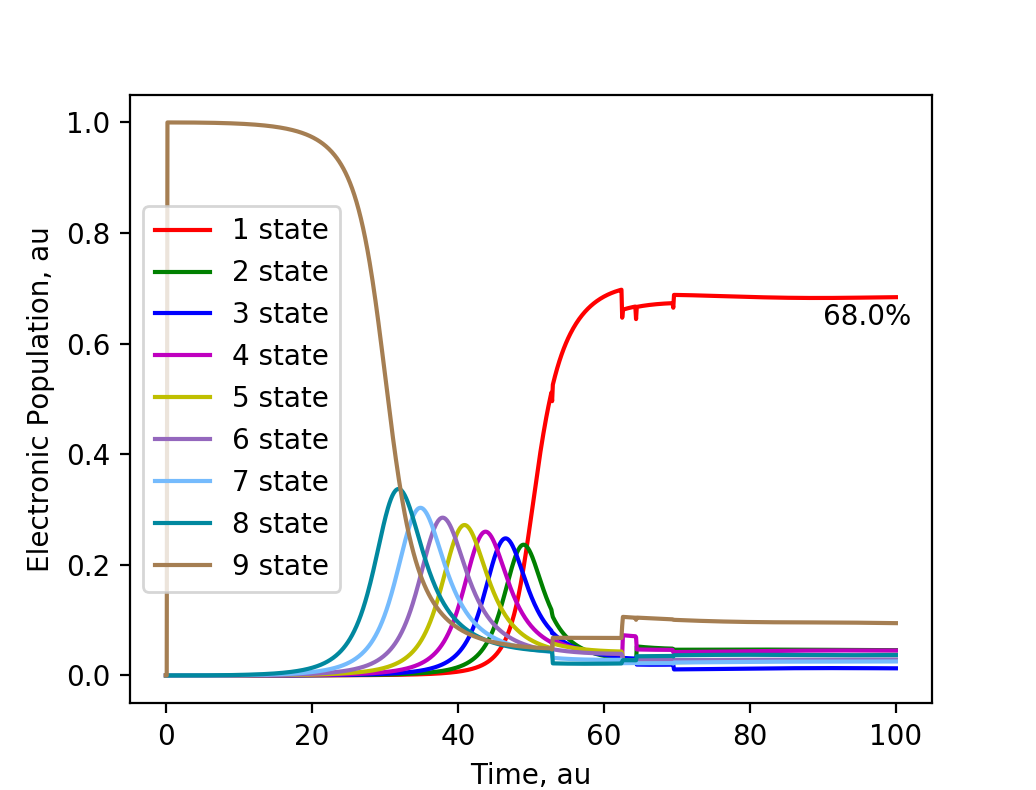

In [37]:
%matplotlib notebook
plot_total_pop()

# Electronic State Populations

Here we plot the electronic state populations on each trajectory. When there are many electronic states it gets messy very quick, so pick the trajectories you want before plotting 

<IPython.core.display.Javascript object>


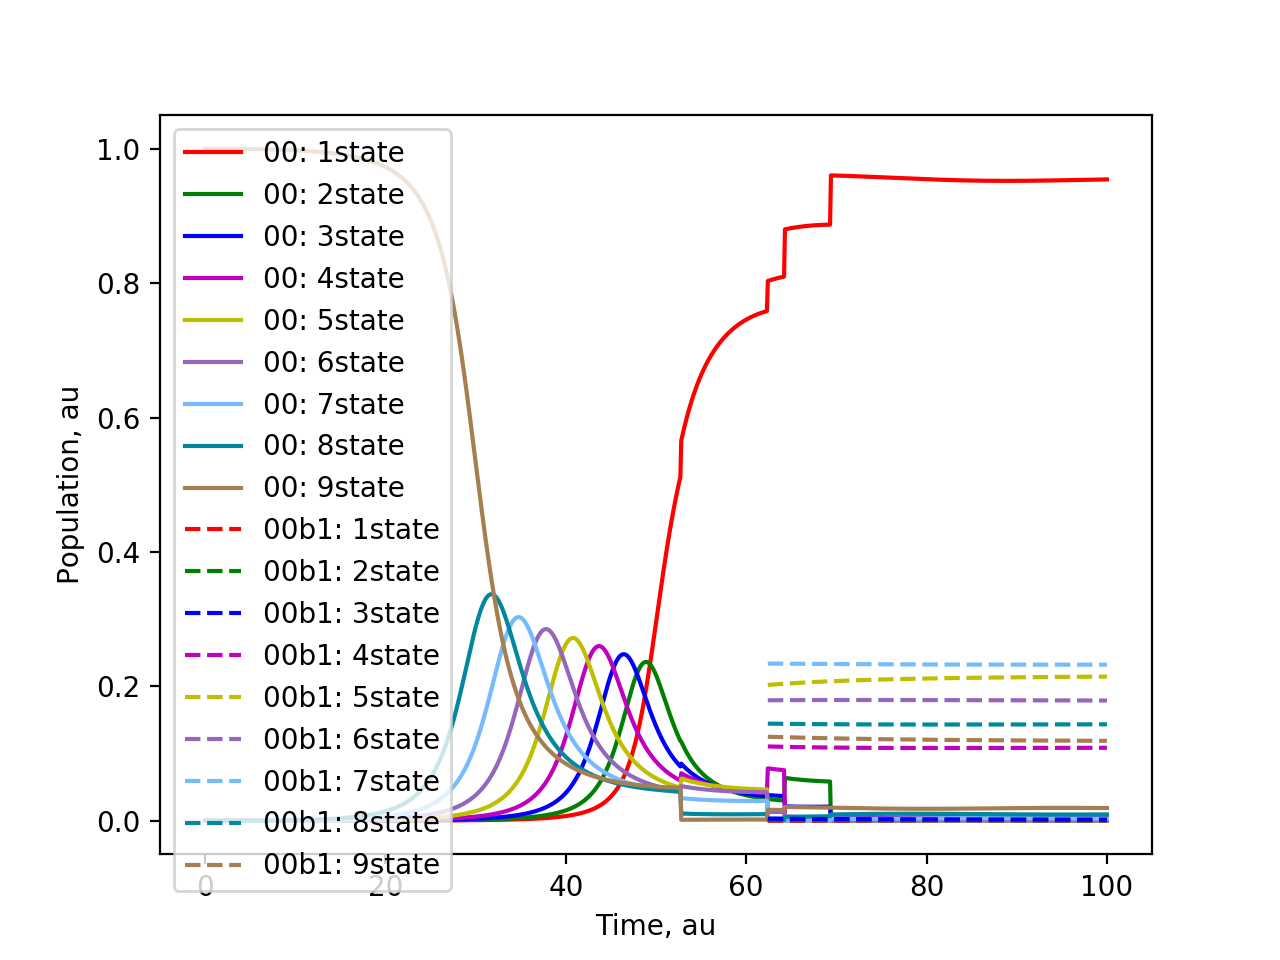

In [39]:
#labels_to_plot = labels
labels_to_plot = ["00", "00b1"]
plot_el_population(labels_to_plot, nstates, colors, linestyles, markers)

# Potential Energies

Plotting potential energies (colored lines) of all eigenstates along with Ehrenfest energies (black lines). To take a closer look we can pass an array of trajectory labels we want to see

<IPython.core.display.Javascript object>


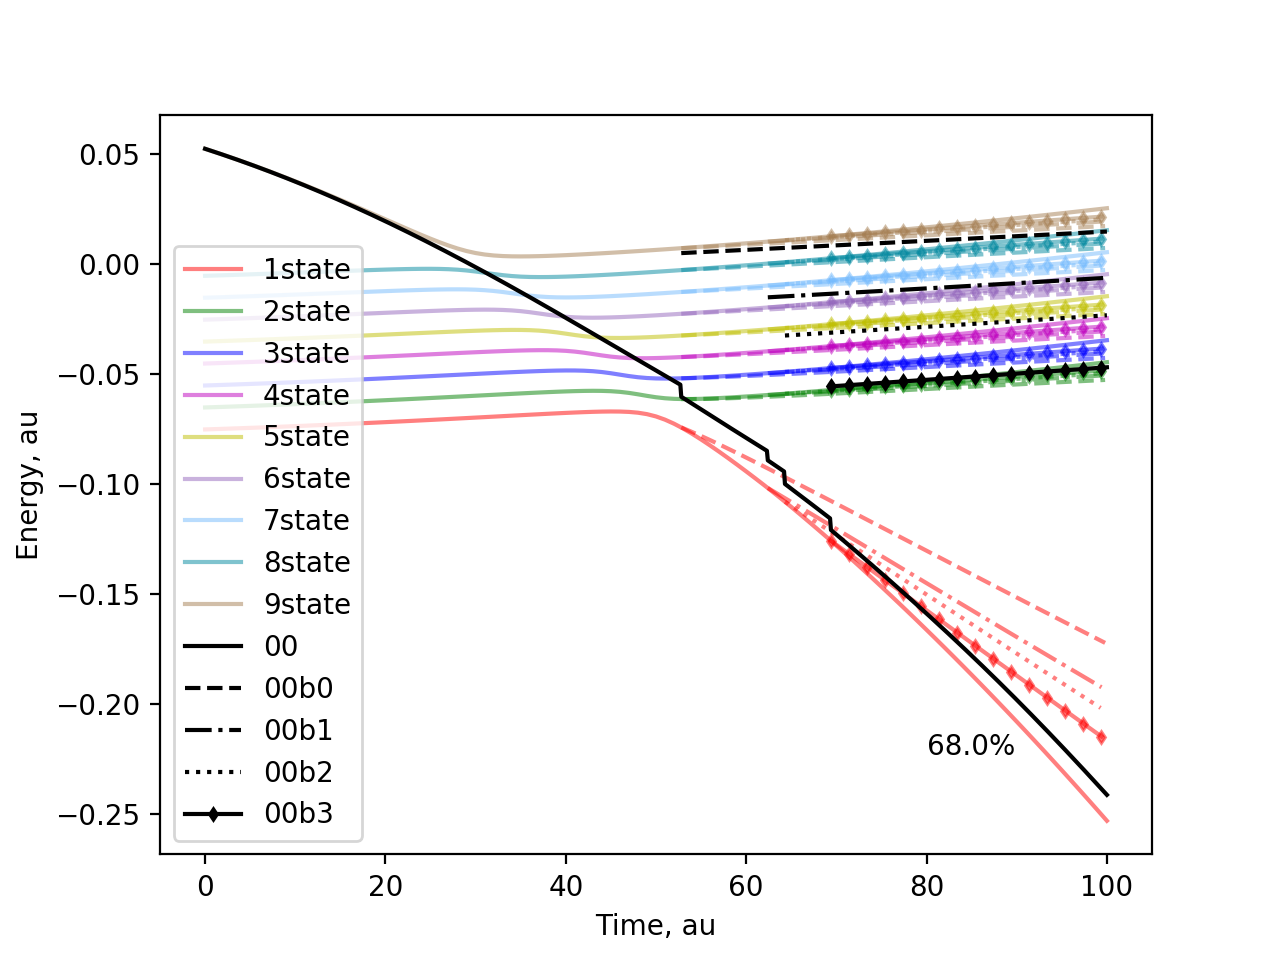

In [45]:
%matplotlib notebook
plot_energies(labels, nstates, colors, linestyles, markers)

# Approximate Eigenstate Energies

Here we plot the Ehrenfest energies and approximate eigenstate energies

<IPython.core.display.Javascript object>


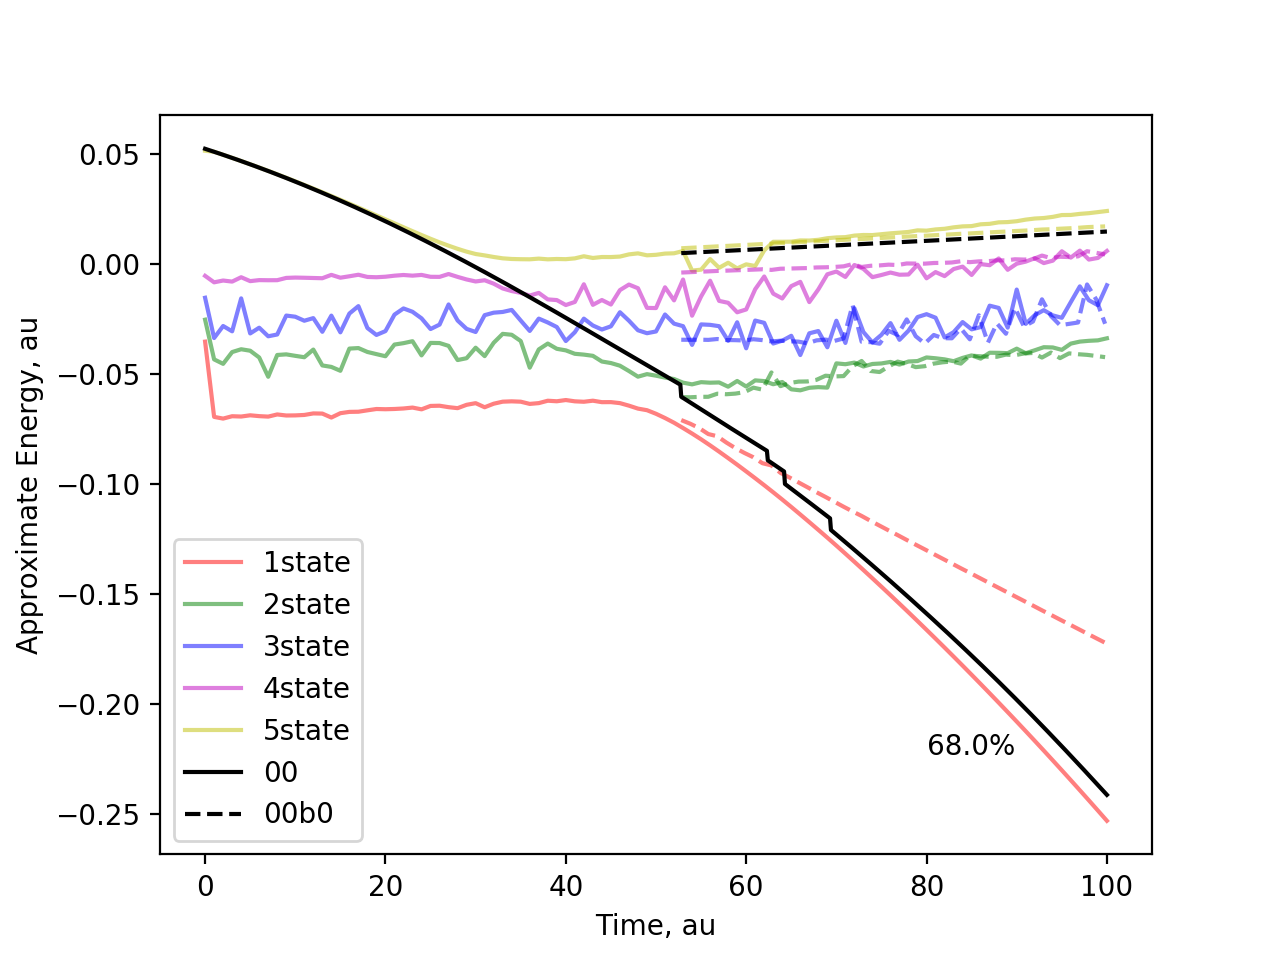

In [52]:
plot_approx_energies(["00", '00b0'], krylov_sub_n, colors, linestyles, markers)

# Plotting Nuclear Populations

The following are the Mulliken nuclear populations on each trajectory, in regions where overlap is not close to zero potentially they can be negative 

<IPython.core.display.Javascript object>


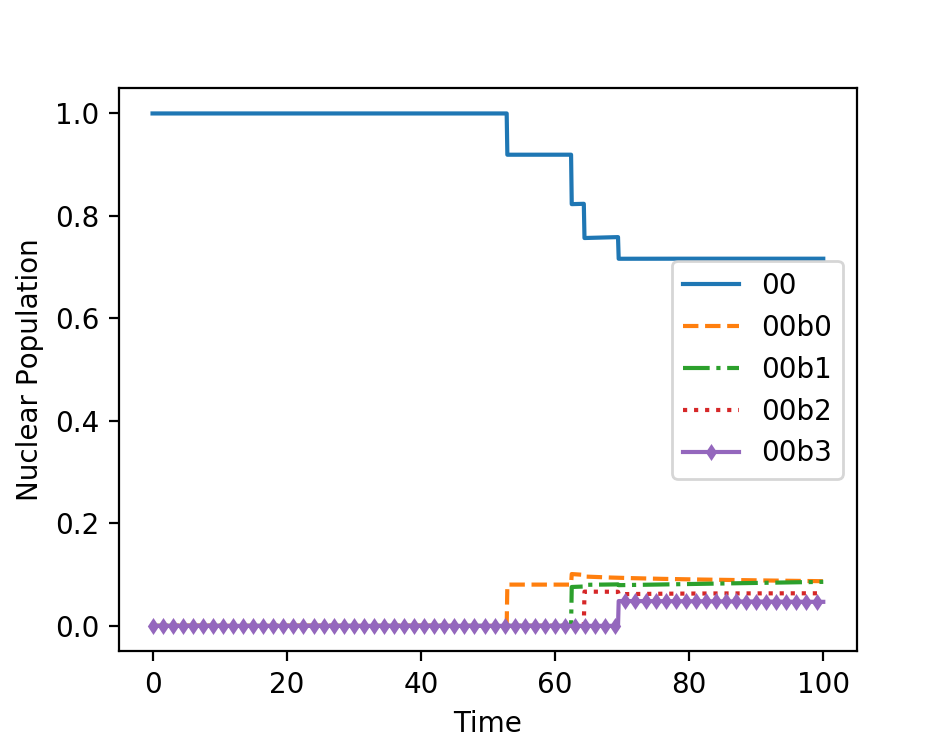

In [46]:
plot_nuclear_populations(labels, ntraj, colors, linestyles, an.datasets["labels"], markers)

# Plotting Total Energies

This is useful to make sure that the classical energy is conserved for all trajectories and nothing weird is going on

<IPython.core.display.Javascript object>


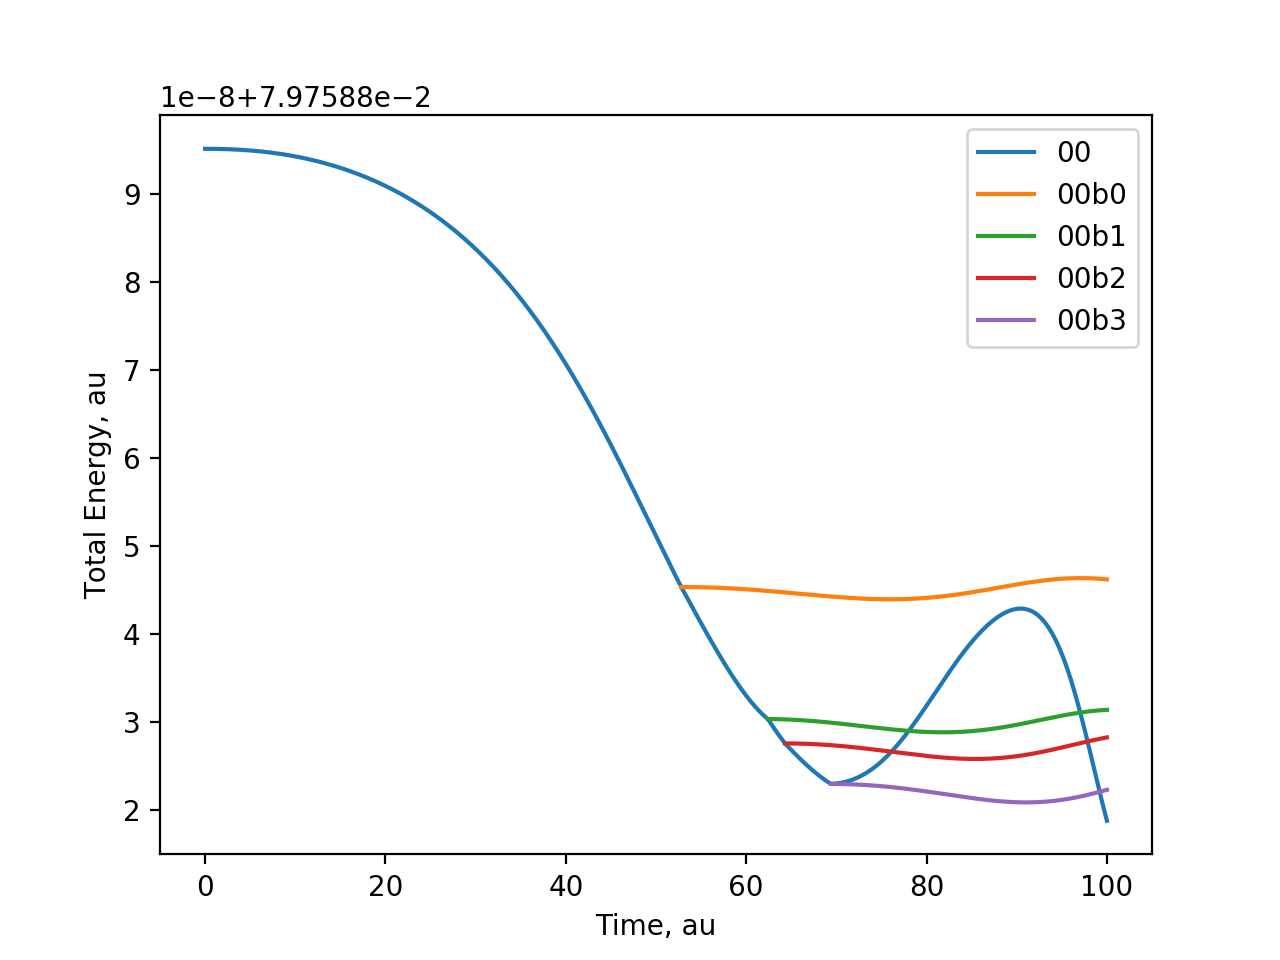

In [49]:
plot_total_energies(an.datasets["labels"], len(an.datasets["labels"]), colors, linestyles)